# Proyecto Final Machine Learning

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from scipy import stats
import pickle

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from scipy.optimize import curve_fit

import warnings
warnings.filterwarnings("ignore")

sns.set_style("whitegrid")

## Carga y Limpieza de datos

In [ ]:
''' Se cargan los datos '''
df = pd.read_csv('AirQualityUCI.csv', sep=';')
df.drop(columns=['Unnamed: 15','Unnamed: 16'], inplace=True)
df.dropna(inplace=True)

''' Se cambia al formato deseado '''
cols = [col  for col in df.columns if df[col].dtype == 'O' and col != 'Time']
df['Time'] = df['Time'].str.replace('.',':')
df[cols] = df[cols].replace(',','.',regex = True)
df[df.columns[2:]] = df[df.columns[2:]].astype(float)
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df['Time'] = pd.to_timedelta(df['Time'], errors = 'ignore')

''' Indice como fecha y los valores -200 se pasan a nan'''
df.index = df['Date'] + df['Time']
df.drop(['Date','Time'],axis=1,inplace=True)
df = df.replace(-200,np.nan)
df.index.name = 'Fecha'
df.head()

## Datos Faltantes

In [ ]:
import missingno as msno

In [ ]:
""" Cuantos nan hay por columna """
df.isna().sum()

In [ ]:
''' Se quitan las columnas con demasiados nan '''
df.drop(['NMHC(GT)'],axis=1,inplace=True)

In [ ]:
''' Distribucion de los nan '''
fig =msno.matrix(df[df.isnull().sum().index], labels=True, sparkline=False, figsize=(10,5), fontsize=10)
fig_copy = fig.get_figure()
plt.show()

In [ ]:
def plot_cols(col1,col2):
    '''Plot de columna 2 versus columna 1 '''
    df_nan = df[[col1,col2]].dropna()
    plt.figure(figsize=(15,7))
    plt.plot(df_nan.values.T[0],df_nan.values.T[1],'o')
    plt.xlabel(col1,fontsize=15)
    plt.ylabel(col2,fontsize=15)
    plt.title('Comparacion '+col2+' con '+col1,fontsize=15)

Se usara la relacion entre las columnas GT y PT para rellenar los datos faltantes (siempre que se pueda).

In [ ]:
plot_cols('CO(GT)','PT08.S1(CO)')
plot_cols('NOx(GT)','PT08.S3(NOx)')
plot_cols('NO2(GT)','PT08.S4(NO2)')

Al observar los graficos se ve que para las primeras dos comparaciones es favorable ajustar una curva a los datos.

In [ ]:
def Regresion_Lineal(columnas):
    df_nan = df[columnas].dropna() 
    X = df_nan[[columnas[0]]].values
    y = df_nan[columnas[1]].values
    regr = linear_model.RidgeCV().fit(X,y)
    return regr

def curve(x,a,b,c):
    return a*np.exp(-b*x)+c

def Regresion_Nolineal(columnas):
    df_nan = df[columnas].dropna() 
    X = df_nan[columnas[0]].values
    y = df_nan[columnas[1]].values
    regr,cov = curve_fit(curve,X,y)
    return regr

In [ ]:
modeloCO = Regresion_Lineal(['CO(GT)','PT08.S1(CO)'])
modeloNOx = Regresion_Nolineal(['NOx(GT)','PT08.S3(NOx)'])

In [ ]:
def plot_fit(col1,col2,modelo):
    '''Plot del ajuste del modelo, para columna 2 versus columna 1 '''
    df_nan = df[[col1,col2]].dropna()
    X = df_nan.values[:,0].reshape(-1,1)
    try:
        y_pred = modelo.predict(X)
        tipo = ''
    except:
        y_pred = curve(X,*modelo)
        tipo = '.'
    y = df_nan.values[:,1]
    plt.figure(figsize=(15,7))
    plt.plot(X,y,'o')
    plt.plot(X,y_pred,tipo)
    plt.xlabel(col1,fontsize=15)
    plt.ylabel(col2,fontsize=15)
    plt.title('Ajuste '+col2+' con respecto a '+col1,fontsize=15)
    plt.show()

In [ ]:
plot_fit('CO(GT)','PT08.S1(CO)',modeloCO)
plot_fit('NOx(GT)','PT08.S3(NOx)',modeloNOx)

In [ ]:
def rellenar_nan(col1,col2,modelo):
    '''Relleno de datos faltantes dado un modelo ajustado, sino hay modelo se usa fillna de pandas '''
    if col2 == '':
        df[col1] = df[col1].fillna(method = modelo)
    else:
        df_col = df[[col1,col2]]
        indice = df_col[df_col.isnull().any(1)].dropna(axis=0,how='all').index
        hola1 = df_col.loc[indice][[col1]]
        hola2 = df_col.loc[hola1[hola1.isnull().any(1)].index]
        indice_importante = hola2.index
        X = hola2.values[:,1:2]
        try:
            new_df = pd.DataFrame(modelo.predict(X),index = indice_importante,columns = [col1])
        except:
            new_df = pd.DataFrame(curve(X,*modelo),index = indice_importante,columns = [col1])
        df.fillna(new_df[[col1]],inplace=True)

In [ ]:
rellenar_nan('PT08.S1(CO)','CO(GT)',modeloCO)
rellenar_nan('PT08.S3(NOx)','NOx(GT)',modeloNOx)
rellenar_nan(['PT08.S1(CO)','PT08.S2(NMHC)','PT08.S3(NOx)','PT08.S5(O3)','PT08.S4(NO2)','T','RH','AH'],'','ffill')
df.dropna(axis=1,inplace=True)

In [ ]:
'''Guardar el dataframe en pickle '''
df.to_pickle("el_df.pkl")

In [3]:
'''Cargar los datos, ya procesados '''
df = pd.read_pickle("el_df.pkl")
df.head()

,PT08.S1(CO),PT08.S2(NMHC),PT08.S3(NOx),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
Fecha,,,,,,,,
2004-03-10 18:00:00,1360.0,1046.0,1056.0,1692.0,1268.0,13.6,48.9,0.7578
2004-03-10 19:00:00,1292.0,955.0,1174.0,1559.0,972.0,13.3,47.7,0.7255
2004-03-10 20:00:00,1402.0,939.0,1140.0,1555.0,1074.0,11.9,54.0,0.7502
2004-03-10 21:00:00,1376.0,948.0,1092.0,1584.0,1203.0,11.0,60.0,0.7867
2004-03-10 22:00:00,1272.0,836.0,1205.0,1490.0,1110.0,11.2,59.6,0.7888


## Distribución de los datos

In [4]:
import plotly.graph_objects as go

In [5]:
def plot_data_distribution(df):
    '''Vista previa de la distribución de los datos, sin considerar la dependencia temporal '''
    
    fig, ax = plt.subplots(nrows=4, ncols=2, figsize=[17, 17])
    fig.tight_layout()

    # list(map(lambda a : a.remove(), ax[-1,1:]))
    fig.suptitle('Distribuciones previa dependencia del tiempo',
                fontsize=20,
                x=0.5,
                y=1.05)

    for axis, col in zip(ax.flatten(), df.columns[:]):
        try :
            sns.distplot(df[col], ax=axis, rug=True)
                
        except RuntimeError:
            sns.distplot(df[col], ax=axis, rug=True, kde=False)
        
        axis.set_xlabel(col, fontsize=15)

    plt.subplots_adjust(wspace=0.4, hspace=0.4)

def plot_tiempo(columna):
    '''Grafico de la columna deseada en funcion del tiempo, usando plotly '''
    fig = go.Figure([go.Scatter(x=df.index, y=df[columna])])
    fig.update_layout(title={'text': f"{columna} en función del tiempo", 'y':0.9, 'x':0.5, 
                             'xanchor': 'center', 'yanchor': 'top'},
                      xaxis_title="Fecha",
                      yaxis_title=f"{columna}",
                      font=dict(size=15),
                      width=900, height=500)
    fig.show()

In [ ]:
'''Distribucion de los datos, sin considerar la dependencia temporal '''
plot_data_distribution(df)

In [ ]:
''' Datos en funcion del tiempo '''
for col in df.columns:
    plot_tiempo(col)

## Distribución outliers

In [ ]:
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=[17, 17])
fig.tight_layout()
fig.suptitle('Distribucion boxplot de los datos', fontsize=20, x=0.5, y=1.05)
for axis, col in zip(ax.flatten(), df.columns[:]):
    df[col].plot.box(ax = axis)
plt.subplots_adjust(wspace=0.4, hspace=0.4)

In [ ]:
# que hacer con los outliers???

## Análisis de correlación

In [ ]:
df_corr = df.corr()
df_corr

Se puede apreciar que las columnas de interes (concentraciones) tienen una alta correlacion entre ellas, pero no asi con la temperatura y la humedad (NO2 igual un poco)

In [ ]:
'''Diccionario con posibles variables para predecir variables de interes '''
dic_pred = dict()
for x in df_corr.columns:
    dic_pred[x]=[]
    for y in df_corr.columns:
        if abs(df_corr.loc[x,y]) > 0.5:
            dic_pred[x].append(y)
del dic_pred['T'], dic_pred['RH'], dic_pred['AH']
for key,value in dic_pred.items():
    print(f"{key}: {value}")

## Matraca prediccion

Como primer acercamiento, se estudiará el desempeño del modelo ARIMA para la variable CO, que se muestra a continuación.

In [70]:
plot_tiempo('PT08.S1(CO)')

In [83]:
df[['PT08.S1(CO)']].describe()

,PT08.S1(CO)
count,9357.000000
mean,1103.143756
std,217.856583
min,647.000000
25%,940.000000
50%,1066.000000
75%,1235.000000
max,2070.321586


In [84]:
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [6]:
def train_test_split(df,tamaño = 0.8):
    X_train = df[:int(df.shape[0]*(tamaño))]
    X_test = df[int(df.shape[0]*tamaño):]
    return X_train,X_test

X_train, X_test = train_test_split(df)

In [ ]:
def Modelo_auto_arima(columna):
    df_train = X_train[columna]
    print('Encontrar Parametros Optimos')
    model = auto_arima(df_train, start_p=24, start_q=6, max_p=24, max_q=6, d=0, max_d=0,
                       seasonal = True,trace=True,error_action='ignore',suppress_warnings=True, stepwise=True)
    print('Fiteo Terminado')
    return model.get_params()

In [ ]:
try:
    params_model = pickle.load(open('params_modelo.pkl','rb'))
except:
    params_model = Modelo_auto_arima('PT08.S1(CO)')

model = SARIMAX(X_train['PT08.S1(CO)'], **params_model)
model = model.fit()
print(model.summary())

In [132]:
def error_pred(test, prediccion):
    '''Retorna el Mean Absolute Error y el Mean Squared Error de la prediccion versus el testeo'''
    mae = np.mean(abs(test-prediccion))
    mse = np.mean((test-prediccion)**2)
    return mae, mse

def prediccion(modelo, testeo, pasos=24):
    '''Predice la variable una cantidad de pasos al futuro, separada en bloques '''
    y_pred = pd.Series()
    mae_list = []
    mse_list = []
    for k in range(int(len(testeo)/pasos)):
        y_test = testeo[pasos*k : pasos*(k+1)]
        pred = modelo.forecast(steps=pasos, dynamic=True)
        mae, mse = error_pred(y_test, pred)
        y_pred = y_pred.append(pred)
        mae_list.append(mae)
        mse_list.append(mse)
        modelo = modelo.append(y_test)
    return y_pred, mae_list, mse_list

def ploteo(testeo, prediccion, pasos = 24, bloques = 4):
    '''Plotea la prediccion y el valor real para una cierta cantidad de bloques de datos '''
    name = testeo.name
    plt.figure(figsize=(15,7))
    plt.xlabel('Fecha', fontsize=15)
    plt.ylabel(name, fontsize=15)
    plt.title(f'Prediccion de {name} para {bloques} bloques de datos', fontsize=15)
    colores = ['r','b','g','y']
    for k in range(bloques):
        y_test = testeo[pasos*k : pasos*(k+1)]
        y_pred = prediccion[pasos*k : pasos*(k+1)]
        if k>=4:
            k -=4
        if k==0:
            plt.plot(y_test,color=colores[k], label = 'Valor Real')
            plt.plot(y_pred,'o-',color=colores[k], label = 'Predicion')
        else: 
            plt.plot(y_test,color=colores[k])
            plt.plot(y_pred, 'o-',color=colores[k])
    plt.legend(loc='best', fontsize=13)
    plt.show()

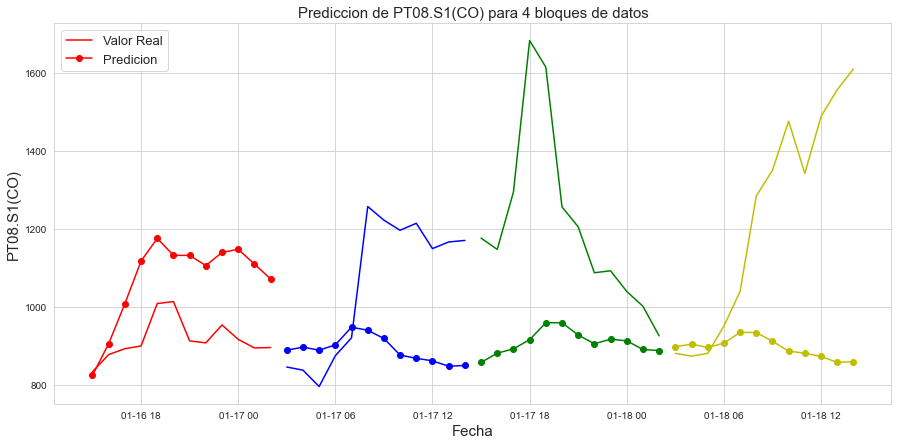

In [146]:
pasos = 12 # pasos al futuro
y_pred, mae_list, mse_list = prediccion(model, X_test['PT08.S1(CO)'], pasos=pasos)
ploteo(X_test['PT08.S1(CO)'], y_pred, pasos = pasos)

In [149]:
y_pred[:12], X_test['PT08.S1(CO)'][:12]

(2005-01-16 15:00:00     823.782183
 2005-01-16 16:00:00     904.896800
 2005-01-16 17:00:00    1007.573219
 2005-01-16 18:00:00    1116.900052
 2005-01-16 19:00:00    1175.251560
 2005-01-16 20:00:00    1131.624898
 2005-01-16 21:00:00    1131.641756
 2005-01-16 22:00:00    1105.484962
 2005-01-16 23:00:00    1139.087858
 2005-01-17 00:00:00    1147.247346
 2005-01-17 01:00:00    1109.505813
 2005-01-17 02:00:00    1071.090357
 dtype: float64,
 Fecha
 2005-01-16 15:00:00     833.0
 2005-01-16 16:00:00     877.0
 2005-01-16 17:00:00     892.0
 2005-01-16 18:00:00     899.0
 2005-01-16 19:00:00    1008.0
 2005-01-16 20:00:00    1013.0
 2005-01-16 21:00:00     912.0
 2005-01-16 22:00:00     907.0
 2005-01-16 23:00:00     953.0
 2005-01-17 00:00:00     916.0
 2005-01-17 01:00:00     894.0
 2005-01-17 02:00:00     895.0
 Name: PT08.S1(CO), dtype: float64)